In [1]:
import pdb
import numpy as np
import matplotlib.pyplot as plt

# for ground-truth comparison
from sklearn.cluster import KMeans
# for generating synthetic data
from sklearn.datasets import make_blobs

#### Broadcasting
Let $X$ be a matrix of dimension $(n, m)$, with $n$ the number of data points and $m$ the feature dimension.
Let $C$ be another matrix of dimension $(k, m)$.
Suppose we want to compute the distance between each row of $X$ and each row of $C$.
A convenient way to do this is using the *broadcasting* functionality from NumPy, as shown below

In [2]:
# Generate synthetic data
n_centers = 5
n_samples = 500
n_features = 2
X, _ = make_blobs(n_samples=n_samples, centers=n_centers, cluster_std=0.60, random_state=0)

# Simulate an arbitrary matrix C to represent the clustering centers
C = np.random.rand(n_centers, n_features)

# Use broadcasting to compute the Euclidean distance
# between each row of X and each row of C.
# The dimension of X becomes (n, 1, m)
# The dimension of C becomes (1, k, m)
# Due to broadcasting, (X - C) has dimension (n, k, m).
# Computing the L2 norm across the last dimension (i.e., axis=2) gives us
# a matrix D of dimension (n, k), where the (i,j)-th entry of D is the
# Euclidean distance between the i-th data point and the j-th center.
D = np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2) ** 2

In [3]:
D.shape

(500, 5)

In [4]:
class SimpleKMeans:
    def __init__(self, k, tol=1e-8, max_iter=100, random_state=123):
        self.centers = None
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize(self, X, k):
        ## kmeans++ initialization for the cluster centers
        ## https://en.wikipedia.org/wiki/K-means%2B%2B
        ## An alternative is just random initialization
        n, m = X.shape[0], X.shape[1]
        centers = np.zeros((k, m))
        # the first center is sampled uniformly at random
        first_center = np.random.randint(0, n)
        centers[0] = X[first_center]

        ## broadcasting
        ## (n, m) - (1, m) = (n, m)
        dist = np.sum((X - centers[0])**2, axis=1)**0.5
        for i in range(1, k):
            probs = dist**2 / np.sum(dist**2)
            ## select the next center with probability proportional
            ## to the distance to the previous center
            center_idx = np.random.choice(n, p=probs)
            centers[i] = X[center_idx]

            if i < k-1:
                new_dist = np.sum((X - centers[i])**2, axis=1)**0.5
                dist = np.minimum(dist, new_dist)
        return centers


    def fit(self, X):
        n, m = X.shape[0], X.shape[1]
        ## randomly initialized the centers
        # idx = np.random.choice(range(n), size=self.k, replace=False)
        # centers = X[idx, :]

        ## initialize the centers with kmeans++
        centers = self.initialize(X, self.k)

        for i in range(self.max_iter):
            ## leverage the broadcasting from NumPy
            ## dist: (n, k)
            dist = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)**2

            ## find the closest center for each data point
            new_assignment = np.argmin(dist, axis=1)
            new_centers = np.zeros((self.k, m))
            for c in range(self.k):
                if np.any(c == new_assignment):
                    new_centers[c] = X[new_assignment == c].mean(axis=0)
                else:
                    ## handle the case where a cluter is not assigned any data point
                    ## if this happens, we pick the farthest data point and assign it to this cluster
                    farthest = np.argmax(np.sum((X - centers[c])**2, axis=1))
                    new_centers[c] = X[farthest]

            if np.linalg.norm(new_centers - centers) < self.tol:
                break
            centers = new_centers
        self.centers = centers

    def predict(self, X):
        ## X:      (n, 1, m)
        ## center: (1, k, m)
        dist = np.linalg.norm(X[:, np.newaxis, :] - self.centers[np.newaxis:, :, ], axis=2)
        assigned_centers = np.argmin(dist, axis=1)
        center_values = self.centers[assigned_centers]
        return assigned_centers, center_values

    def inertia_(self, X):
        ## Compute the within-cluster sum of squared distance (WCSS)
        ## this is used to select the hyper-parameter `k`
        assigned_centers, center_values = self.predict(X)
        wc_dist = 0.0
        for i, center in enumerate(self.centers):
            ## (c, m) - (m, ) = (c, m) - (1, m)
            dist = np.sum((X[assigned_centers == i] - center)**2, axis=1)
            wc_dist += np.sum(dist)
        return wc_dist


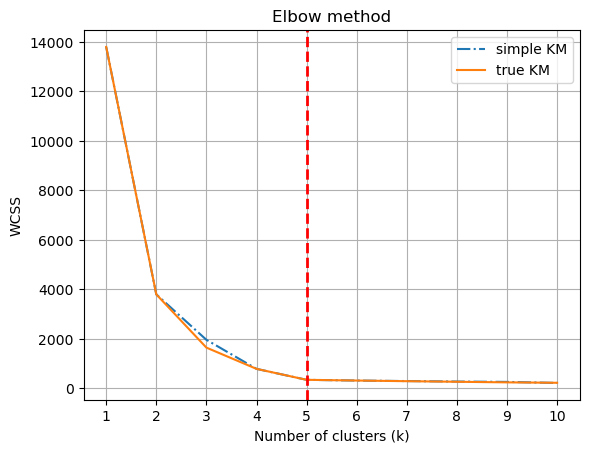

In [5]:
# Apply the simple KMeans with a range of k values and plot the WCSS
# The best k is attained at the point where the WCSS doesn't significantly descrease.
# In our case, the best k should be around 5.

seed = 123
np.random.seed(seed)

# Compare the customized implementation with the ground-truth implementation from scikit-learn
cust_wcss = []
true_wcss = []

for i in range(1, 11):  # Test k from 1 to 10
    simple_km = SimpleKMeans(k=i, random_state=seed)
    simple_km.fit(X)
    cust_wcss.append(simple_km.inertia_(X))

    true_km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=seed)
    true_km.fit(X)
    true_wcss.append(true_km.inertia_)

# Plot the WCC for both simple K-means and true K-means.
# The lines are almost overlapping
plt.plot(range(1, 11), cust_wcss, label='simple KM', linestyle='-.')
plt.plot(range(1, 11), true_wcss, label='true KM')
plt.title('Elbow method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.axvline(x=5, color='r', linestyle='--', linewidth=2)
plt.legend()
plt.show()